In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from sklearn.metrics import accuracy_score
import h5py

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
RESEARCH_WORKSPACE="../data/"

## Load annotations and predictions

In [3]:
annotations = pd.read_csv(os.path.join(RESEARCH_WORKSPACE, 'annotations_ust_2.1.csv'))
annotations = pd.read_csv(os.path.join(RESEARCH_WORKSPACE, 'annotations.csv'))
validate_data = list(np.unique(annotations[(annotations['split']=='validate') &
                                            (annotations['annotator_id']==0)]['audio_filename']))
train_data = list(np.unique(annotations[annotations['split']=='train']['audio_filename']))

In [4]:
len(validate_data)

538

In [6]:
annotations

,split,sensor_id,audio_filename,annotator_id,borough,block,latitude,longitude,year,week,...,7-X_other-unknown-human-voice_proximity,8-1_dog-barking-whining_proximity,1_engine_presence,2_machinery-impact_presence,3_non-machinery-impact_presence,4_powered-saw_presence,5_alert-signal_presence,6_music_presence,7_human-voice_presence,8_dog_presence
0,validate,0,00_000066.wav,95,1,547,40.729508,-73.993881,2017,28,...,far,far,1,1,1,1,1,1,1,1
1,validate,0,00_000066.wav,108,1,547,40.729508,-73.993881,2017,28,...,-1,-1,1,0,0,0,0,0,0,0
2,validate,0,00_000066.wav,127,1,547,40.729508,-73.993881,2017,28,...,-1,-1,1,0,0,0,0,0,0,0
3,validate,0,00_000071.wav,64,1,547,40.729508,-73.993881,2016,50,...,-1,-1,1,0,0,0,0,0,0,0
4,validate,0,00_000071.wav,66,1,547,40.729508,-73.993881,2016,50,...,-1,-1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56775,validate,10,10_003220.wav,-4,1,481,40.721046,-73.997280,2017,44,...,-1,-1,1,-1,-1,-1,-1,-1,-1,-1
56776,validate,10,10_003220.wav,-2,1,481,40.721046,-73.997280,2017,44,...,-1,-1,-1,-1,-1,-1,1,-1,-1,-1
56777,validate,10,10_003220.wav,-1,1,481,40.721046,-73.997280,2017,44,...,-1,-1,1,-1,-1,-1,-1,-1,-1,-1
56778,validate,10,10_003220.wav,-1,1,481,40.721046,-73.997280,2017,44,...,-1,-1,-1,-1,-1,-1,1,-1,-1,-1


In [7]:
annotations.columns

Index(['split', 'sensor_id', 'audio_filename', 'annotator_id', 'borough',
       'block', 'latitude', 'longitude', 'year', 'week', 'day', 'hour',
       '1-1_small-sounding-engine_presence',
       '1-2_medium-sounding-engine_presence',
       '1-3_large-sounding-engine_presence',
       '1-X_engine-of-uncertain-size_presence', '2-1_rock-drill_presence',
       '2-2_jackhammer_presence', '2-3_hoe-ram_presence',
       '2-4_pile-driver_presence',
       '2-X_other-unknown-impact-machinery_presence',
       '3-1_non-machinery-impact_presence', '4-1_chainsaw_presence',
       '4-2_small-medium-rotating-saw_presence',
       '4-3_large-rotating-saw_presence',
       '4-X_other-unknown-powered-saw_presence', '5-1_car-horn_presence',
       '5-2_car-alarm_presence', '5-3_siren_presence',
       '5-4_reverse-beeper_presence',
       '5-X_other-unknown-alert-signal_presence',
       '6-1_stationary-music_presence', '6-2_mobile-music_presence',
       '6-3_ice-cream-truck_presence',
       '6-X

In [8]:
print(len(np.unique(validate_data)), len(np.unique(train_data)))

538 13538


In [9]:
f = open(os.path.join(RESEARCH_WORKSPACE, 'framewise_predictions/results/fine/','predictions_framewise.json'))
fine_predictions = json.load(f)
print(len(fine_predictions))

17846


In [86]:
f = open(os.path.join(RESEARCH_WORKSPACE, 'framewise_predictions/results/coarse/','predictions_framewise.json'))
coarse_predictions = json.load(f)
print(len(coarse_predictions))

17846


In [10]:
print(validate_data[:5], list(predictions.keys())[:5])

['00_000066.wav', '00_000118.wav', '00_000275.wav', '00_000277.wav', '00_000357.wav'] ['00_000066', '00_000071', '00_000085', '00_000118', '00_000179']


#### check predictions include the validation set

In [11]:
is_in_predictions = [f for f in validate_data if f[:-4] in list(fine_predictions.keys())]

In [12]:
len(is_in_predictions)

538

## compute accuracy, precision and recall for different thresholds

#### Start with a few classes, siren and person-or-small-group-talking

In [13]:
classes = ['small-sounding-engine', 'medium-sounding-engine', 'large-sounding-engine', 
          'rock-drill', 'jackhammer', 'hoe-ram', 'pile-driver',
          'non-machinery-impact',
          'chainsaw', 'small-medium-rotating-saw', 'large-rotating-saw',
          'car-horn', 'car-alarm', 'siren', 'reverse-beeper', 
          'stationary-music', 'mobile-music', 'ice-cream-truck',
          'person-or-small-group-talking', 'person-or-small-group-shouting', 
          'large-crowd', 'amplified-speech',
          'dog-barking-whining']

In [14]:
len(fine_predictions['00_000066'][0])

23

In [15]:
len(classes)

23

In [16]:
# remove all X and see if it's too much
# get annotations for interesting classes (e.g. array = different values)
# remove all -1 to 0
# count FP as UST 

In [87]:
classes_fine = ['1-1_small-sounding-engine_presence',
       '1-2_medium-sounding-engine_presence',
       '1-3_large-sounding-engine_presence',
#        '1-X_engine-of-uncertain-size_presence', 
       '2-1_rock-drill_presence',
       '2-2_jackhammer_presence', 
       '2-3_hoe-ram_presence',
       '2-4_pile-driver_presence',
#        '2-X_other-unknown-impact-machinery_presence',
       '3-1_non-machinery-impact_presence', 
       '4-1_chainsaw_presence',
       '4-2_small-medium-rotating-saw_presence',
       '4-3_large-rotating-saw_presence',
#        '4-X_other-unknown-powered-saw_presence', 
       '5-1_car-horn_presence',
       '5-2_car-alarm_presence', 
       '5-3_siren_presence',
       '5-4_reverse-beeper_presence',
#        '5-X_other-unknown-alert-signal_presence',
       '6-1_stationary-music_presence', 
       '6-2_mobile-music_presence',
       '6-3_ice-cream-truck_presence',
#        '6-X_music-from-uncertain-source_presence',
       '7-1_person-or-small-group-talking_presence',
       '7-2_person-or-small-group-shouting_presence',
       '7-3_large-crowd_presence', '7-4_amplified-speech_presence',
#        '7-X_other-unknown-human-voice_presence',
       '8-1_dog-barking-whining_presence',
       ]
classes_coarse = ['1_engine_presence',
       '2_machinery-impact_presence', '3_non-machinery-impact_presence',
       '4_powered-saw_presence', '5_alert-signal_presence', '6_music_presence',
       '7_human-voice_presence', '8_dog_presence']

unknown = ['7-X_other-unknown-human-voice_presence',
           '6-X_music-from-uncertain-source_presence',
            '5-X_other-unknown-alert-signal_presence',
           '2-X_other-unknown-impact-machinery_presence',
           '1-X_engine-of-uncertain-size_presence'
]

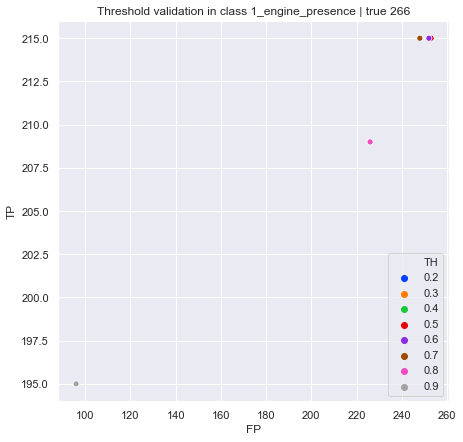

Computed 468 files over 538 total available with annotator 0


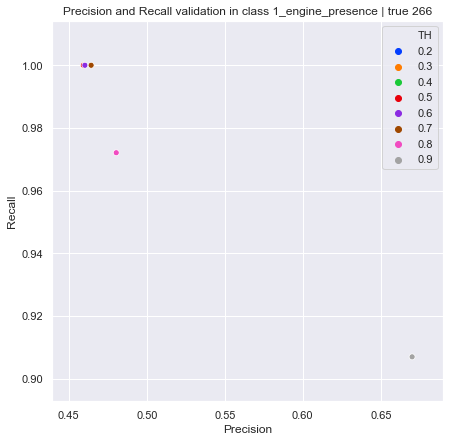

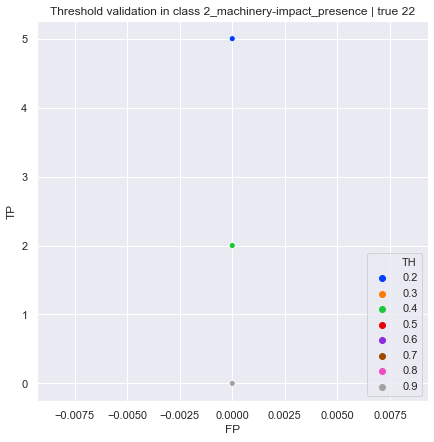

Computed 468 files over 538 total available with annotator 0


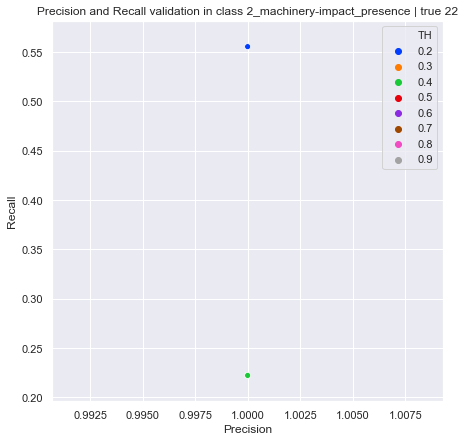

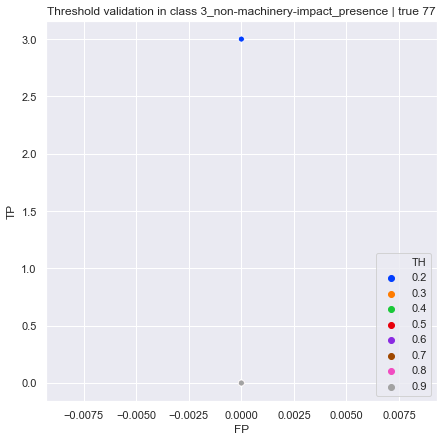

Computed 468 files over 538 total available with annotator 0


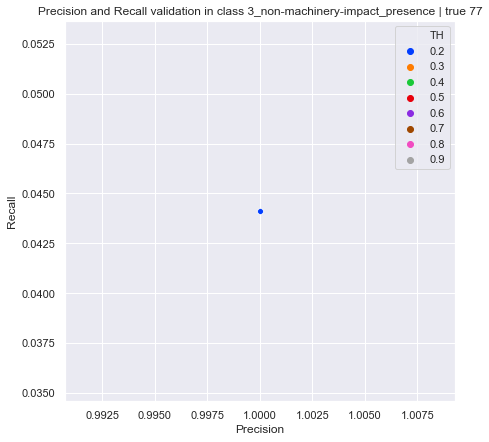

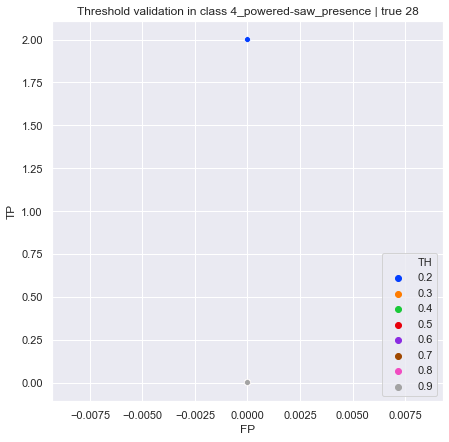

Computed 468 files over 538 total available with annotator 0


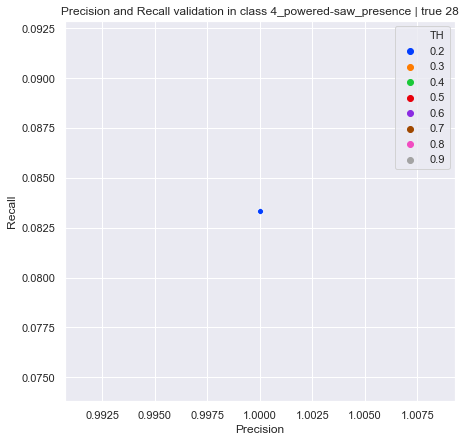

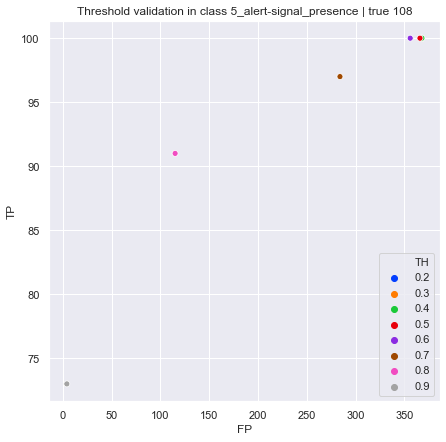

Computed 468 files over 538 total available with annotator 0


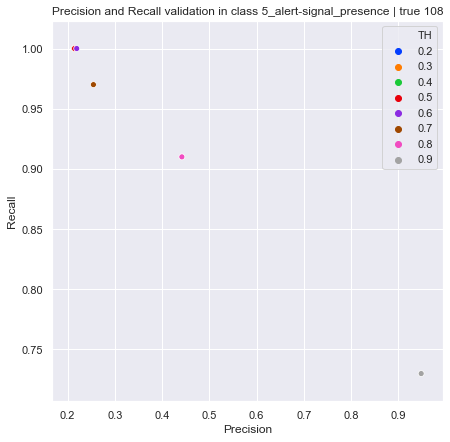

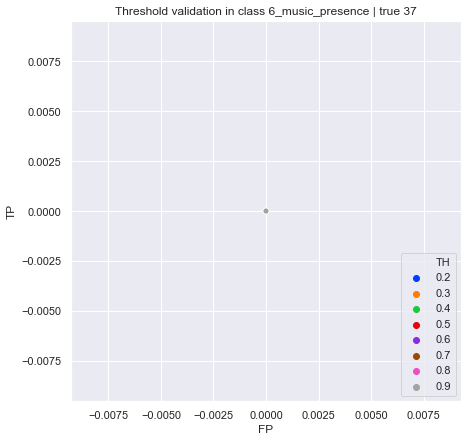

Computed 468 files over 538 total available with annotator 0


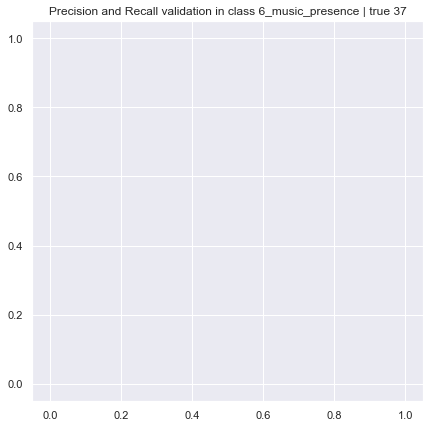

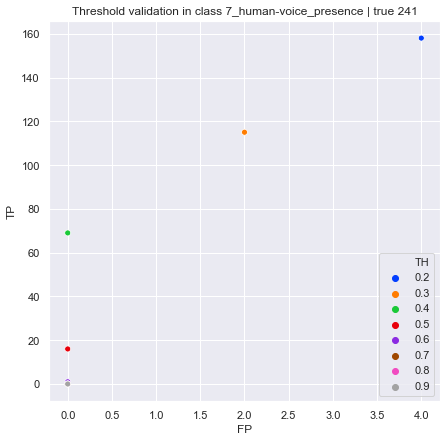

Computed 468 files over 538 total available with annotator 0


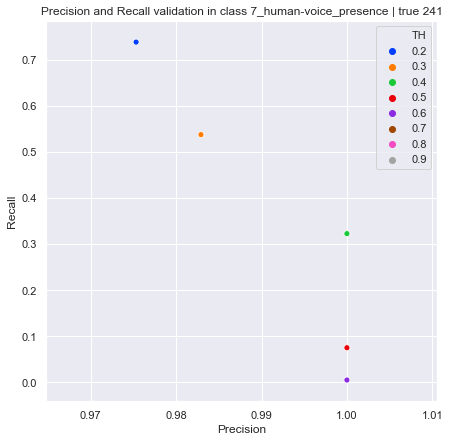

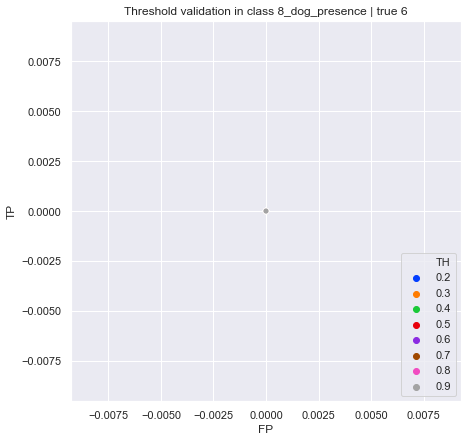

Computed 468 files over 538 total available with annotator 0


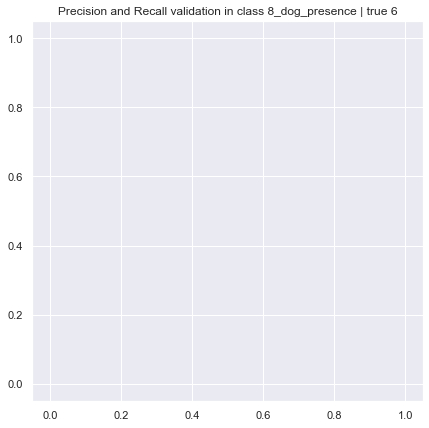

In [112]:
classes = [13, 18, 11, 1]  # classes of interest
classes = np.arange(len(classes_coarse))  # all classes
# classes = [0]
thresholds = np.round(np.arange(0.2, 0.91, 0.1), 2)
res = {}

for c in classes: 
    results = []
    for th in thresholds:
        files = []
        for f in validate_data:
            gth_recording = annotations[(annotations['audio_filename']==f) & (annotations['annotator_id']==0)]
            if np.any(gth_recording): # skip if no annotator 0
                if np.any(gth_recording[gth_recording[unknown]==1]): # skip if X class
                        continue
                gth = gth_recording[classes_coarse+['audio_filename']].set_index(['audio_filename'])
                gth = np.array(gth).astype(float)
#                 print('gth={}'.format(gth))
                y_pred_ = np.array(coarse_predictions[f[:-4]])
                y_pred_ = np.max(y_pred_, axis=0)
#                 print('pred={}'.format(y_pred_))
                y_pred = np.zeros(y_pred_.shape)
                y_pred[y_pred_>th] = 1
#                 print('pred={}'.format(y_pred_))
                gth = gth[:,c]
                y_pred = y_pred[c]
                true_positives_coarse = ((y_pred == gth) & (gth==1)).sum()
                false_positives_coarse = ((y_pred != gth) & (y_pred==1)).sum()
                false_negatives_coarse = ((y_pred != gth) & (y_pred==0)).sum()
                files.append(f)
                results.append([true_positives_coarse, false_positives_coarse, th, false_negatives_coarse])
        
    # scatter results
    results = np.array(results)
    df = pd.DataFrame({'TP':results[:, 0], 'FP':results[:, 1], 'FN': results[:,3], 'TH':results[:, 2]})
    df_ = df.groupby(['TH']).sum().reset_index()
    df_['Precision'] = df_['TP']/(df_['TP']+df_['FP'])
    df_['Recall'] = df_['TP']/(df_['TP']+df_['FN'])
    
    # TP vs. FP
    palette = sns.color_palette("bright", len(thresholds))
    plt.figure(figsize=(7,7))
    plt.title('Threshold validation in class {} | true {}'.format(classes_coarse[c], 
                                                                  annotations[(annotations['split']=='validate')
                                                      & (annotations['annotator_id']==0)][classes_coarse[c]].sum()))
    ax = sns.scatterplot(x="FP", y="TP", hue='TH',
                         data=df_, legend='full', palette=palette)
    ax.legend(loc='lower right', ncol=1)
    plt.show()        
    
    # Recall vs. Precision
    plt.figure(figsize=(7,7))
    plt.title('Precision and Recall validation in class {} | true {}'.format(classes_coarse[c], 
                                                                      annotations[(annotations['split']=='validate')
                                                          & (annotations['annotator_id']==0)][classes_coarse[c]].sum()))
    ax = sns.scatterplot(x="Precision", y="Recall", hue='TH',
                         data=df_, legend='full', palette=palette)
    res[classes_coarse[c]] = results
    print('Computed {} files over {} total available with annotator 0'.format(len(files), len(validate_data)))

In [110]:
df_['F1'] = 2*(df_['Precision']*df_['Recall'])/(df_['Precision'] + df_['Recall'])

In [111]:
df_

,TH,TP,FP,FN,Precision,Recall,F1
0,0.50,215.0,253.0,0.0,0.459402,1.000000,0.629575
1,0.55,215.0,253.0,0.0,0.459402,1.000000,0.629575
2,0.60,215.0,252.0,0.0,0.460385,1.000000,0.630499
3,0.65,215.0,250.0,0.0,0.462366,1.000000,0.632353
4,0.70,215.0,248.0,0.0,0.464363,1.000000,0.634218
5,0.75,212.0,243.0,3.0,0.465934,0.986047,0.632836
6,0.80,209.0,226.0,6.0,0.480460,0.972093,0.643077
7,0.85,206.0,180.0,9.0,0.533679,0.958140,0.685524
8,0.90,195.0,96.0,20.0,0.670103,0.906977,0.770751


### Fine classes

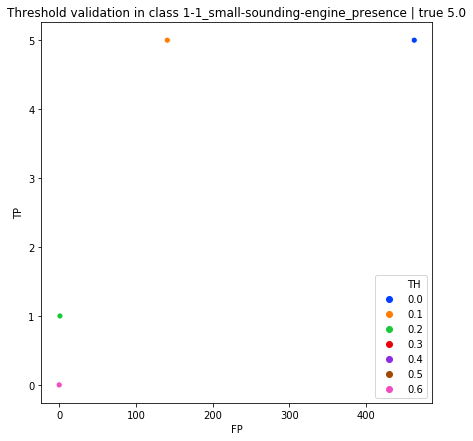

Computed 468 files over 538 total available with annotator 0


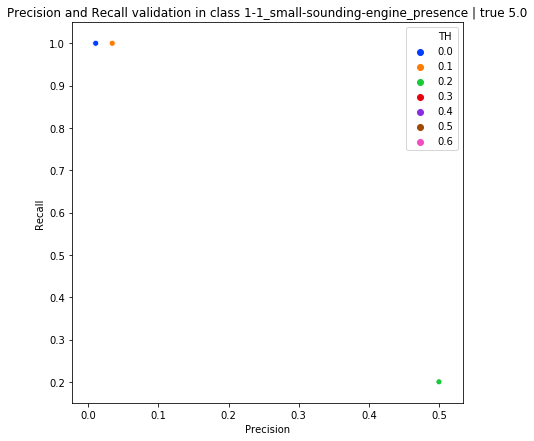

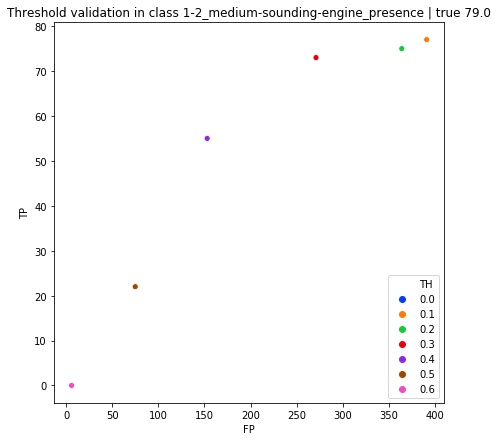

Computed 468 files over 538 total available with annotator 0


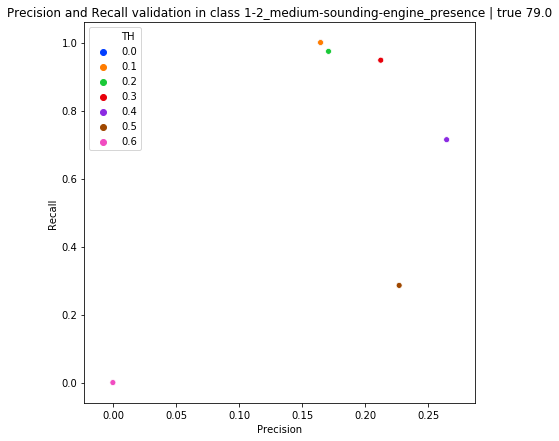

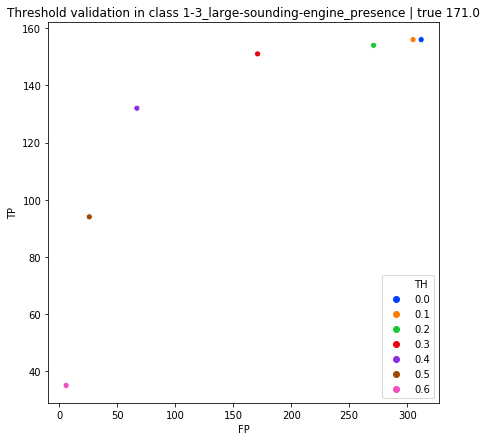

Computed 468 files over 538 total available with annotator 0


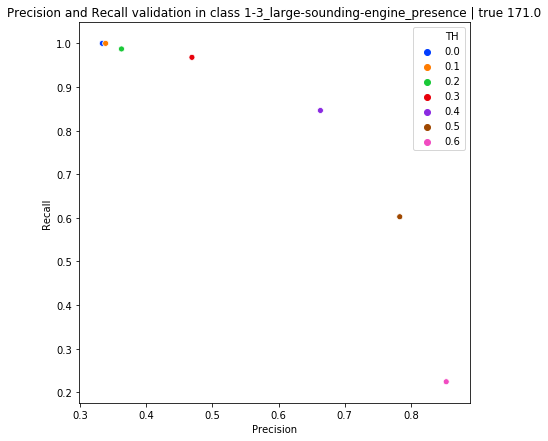

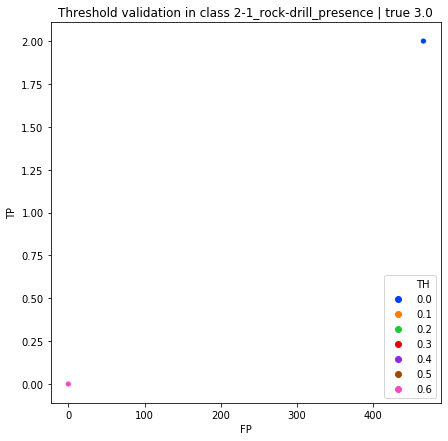

Computed 468 files over 538 total available with annotator 0


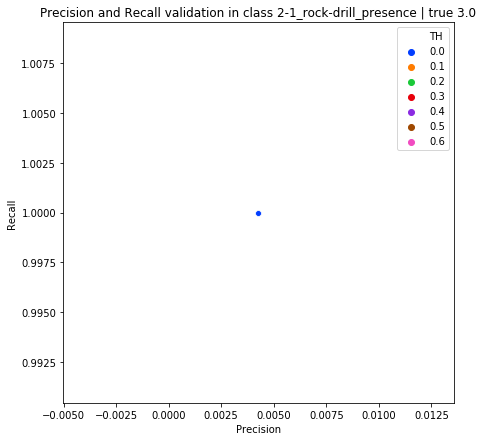

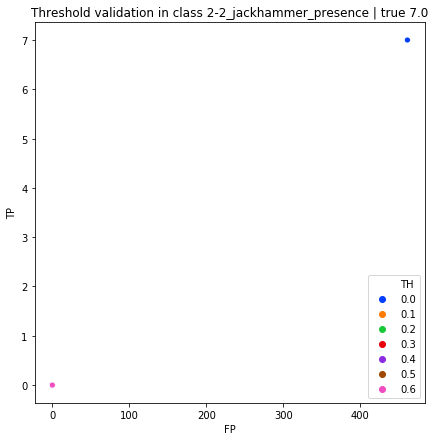

Computed 468 files over 538 total available with annotator 0


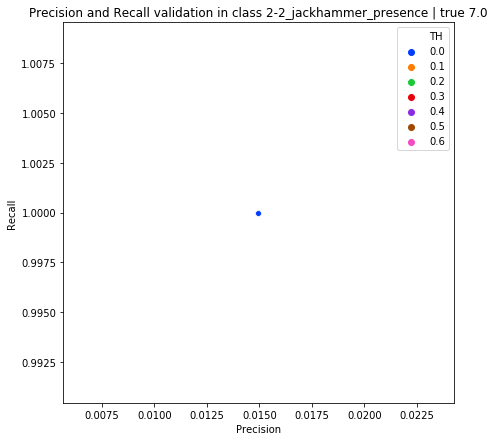

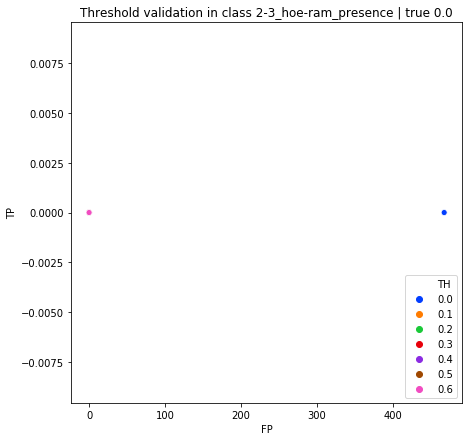

Computed 468 files over 538 total available with annotator 0


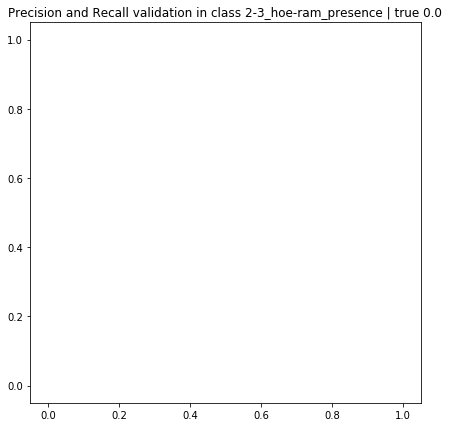

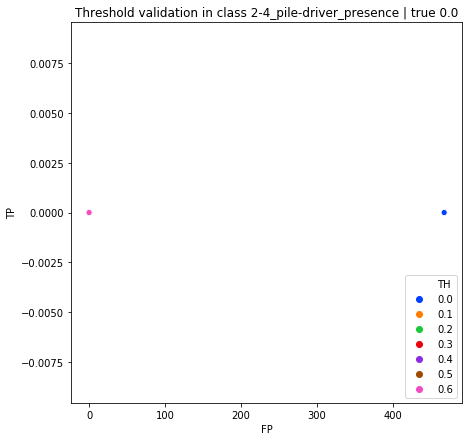

Computed 468 files over 538 total available with annotator 0


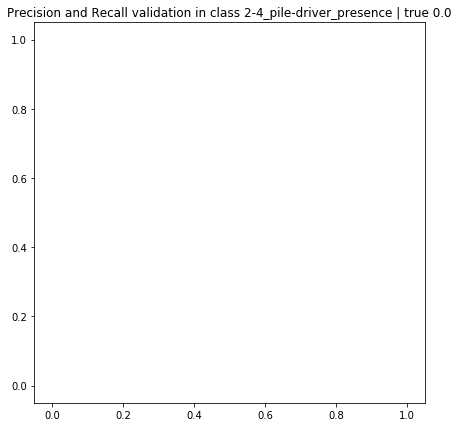

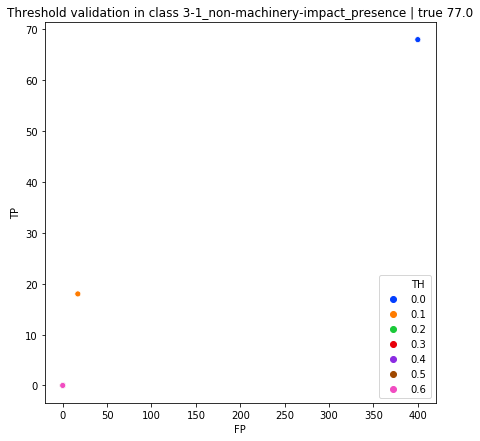

Computed 468 files over 538 total available with annotator 0


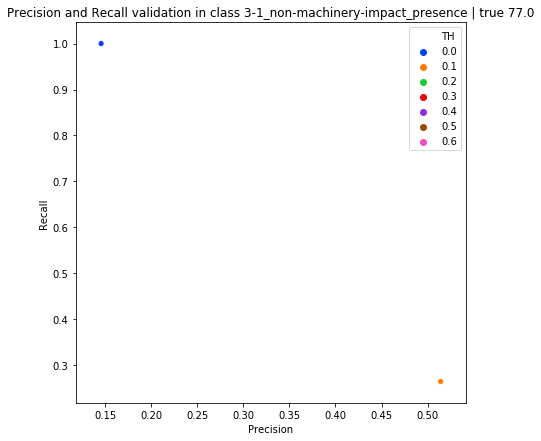

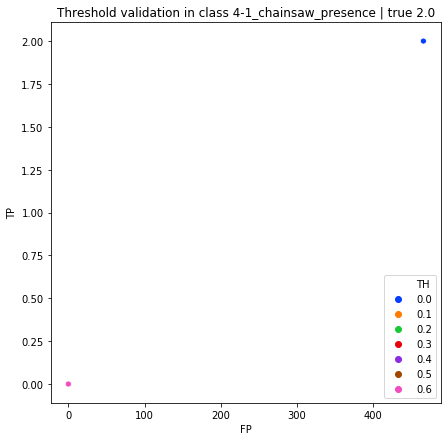

Computed 468 files over 538 total available with annotator 0


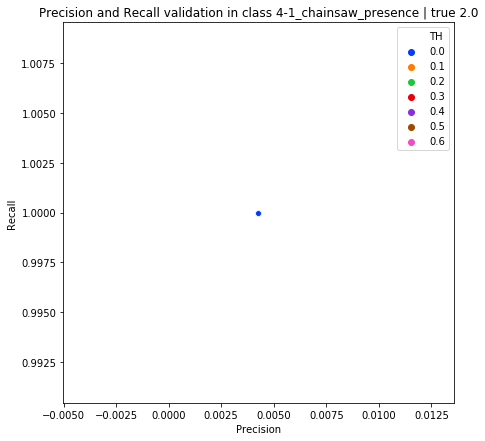

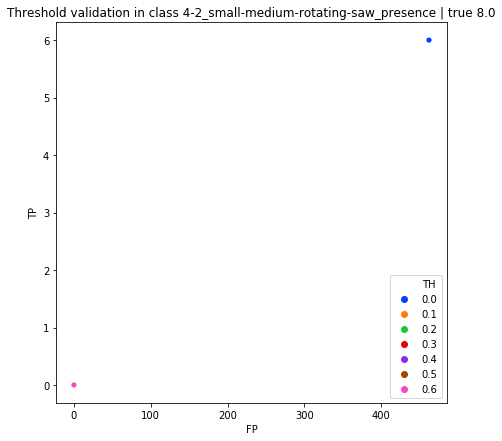

Computed 468 files over 538 total available with annotator 0


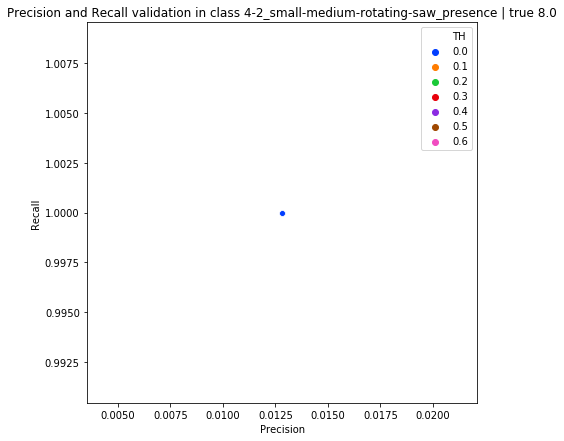

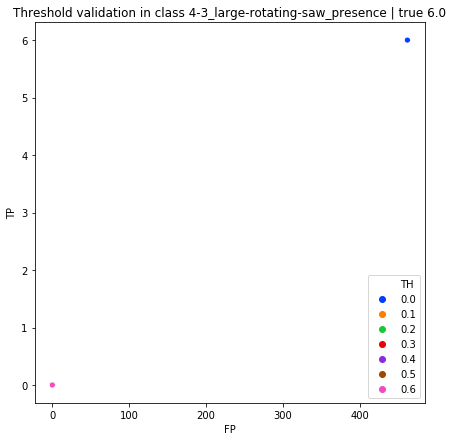

Computed 468 files over 538 total available with annotator 0


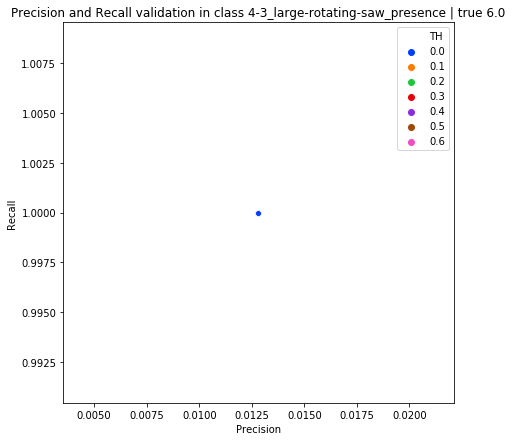

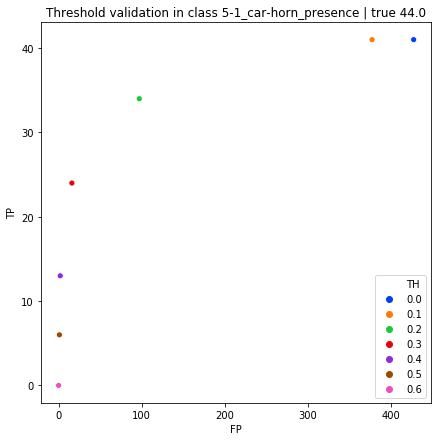

Computed 468 files over 538 total available with annotator 0


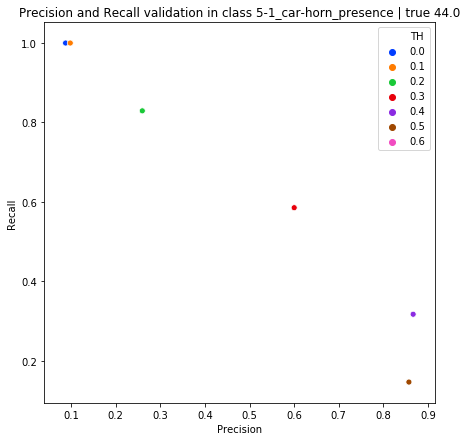

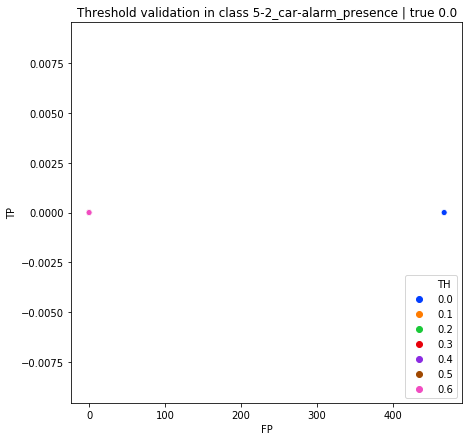

Computed 468 files over 538 total available with annotator 0


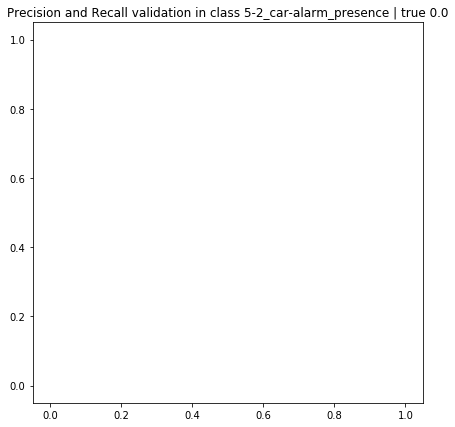

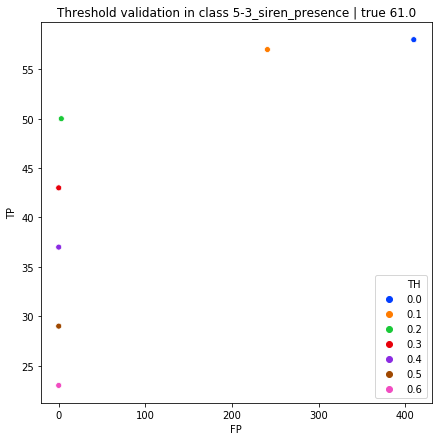

Computed 468 files over 538 total available with annotator 0


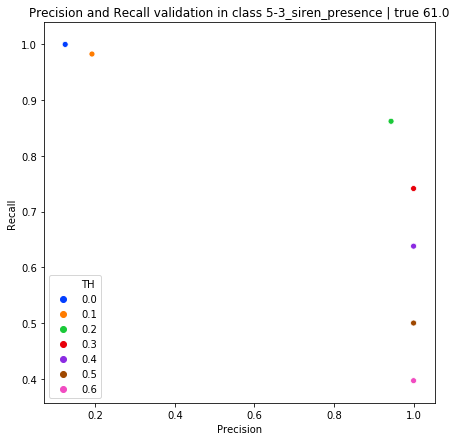

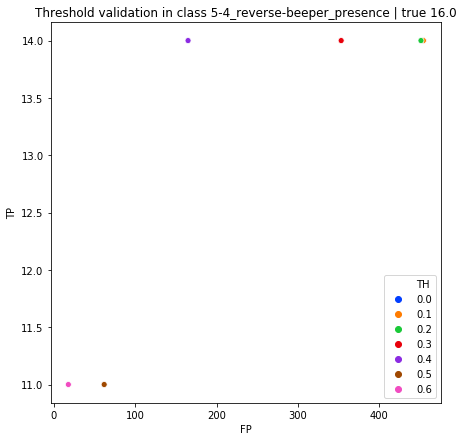

Computed 468 files over 538 total available with annotator 0


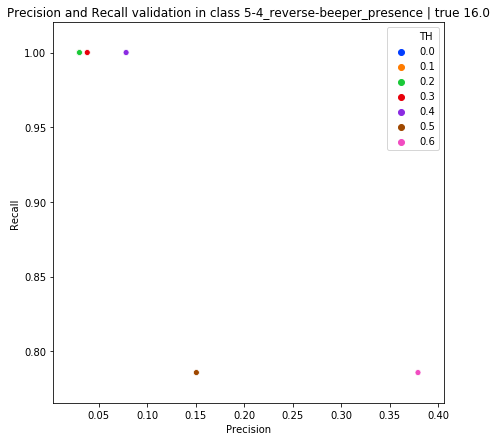

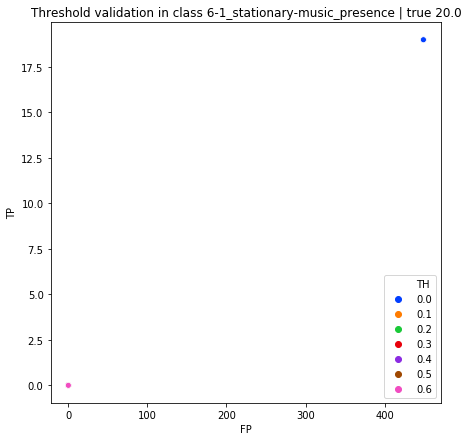

Computed 468 files over 538 total available with annotator 0


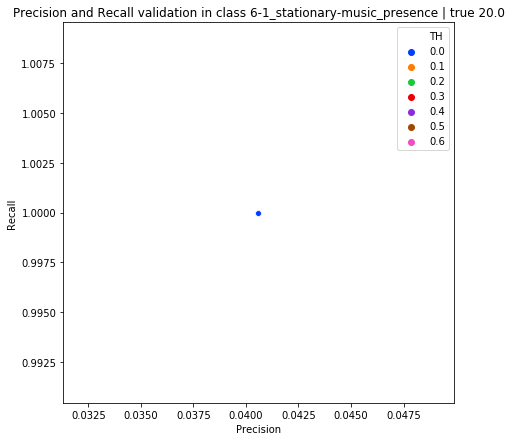

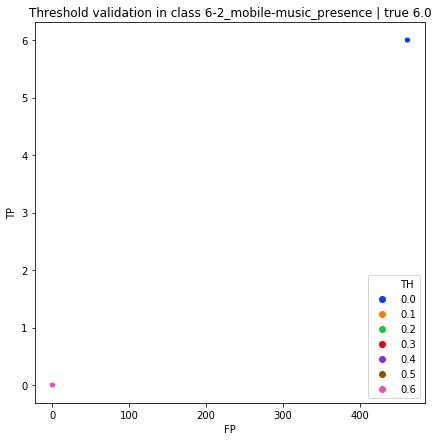

Computed 468 files over 538 total available with annotator 0


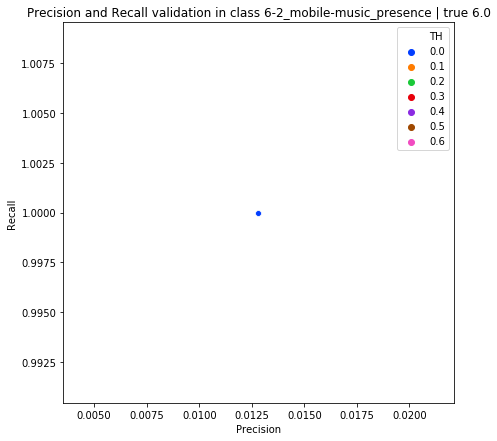

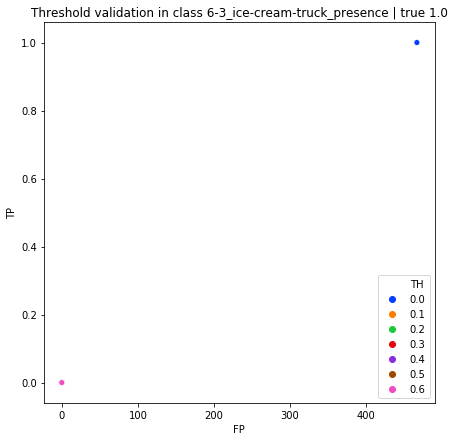

Computed 468 files over 538 total available with annotator 0


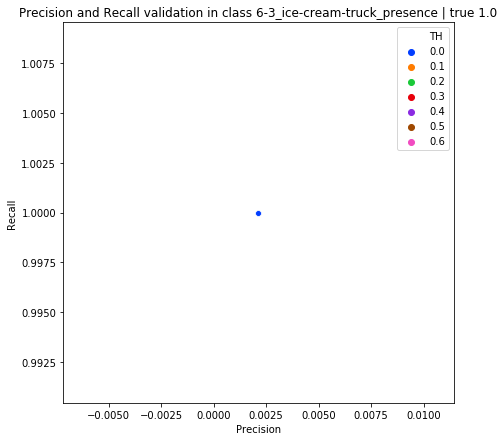

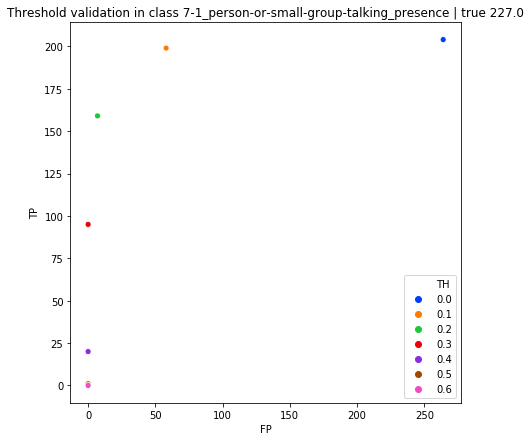

Computed 468 files over 538 total available with annotator 0


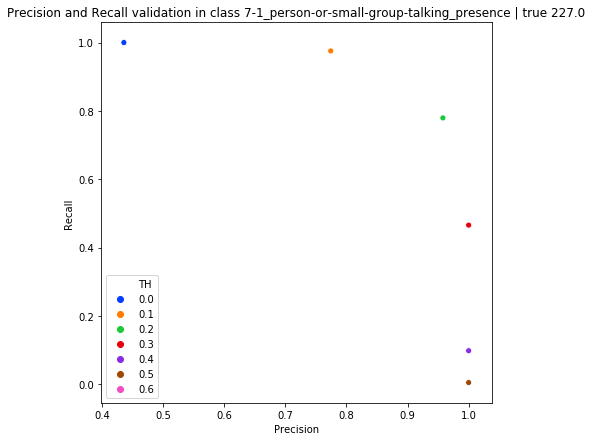

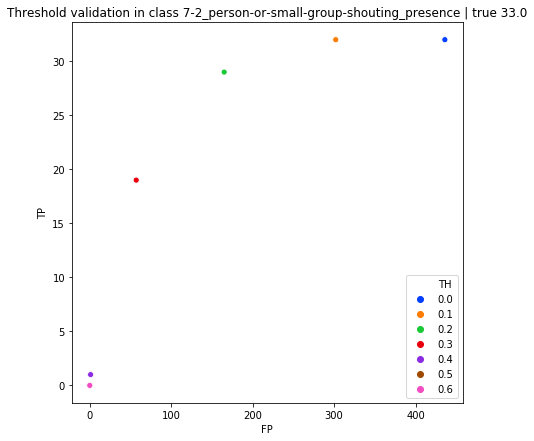

Computed 468 files over 538 total available with annotator 0


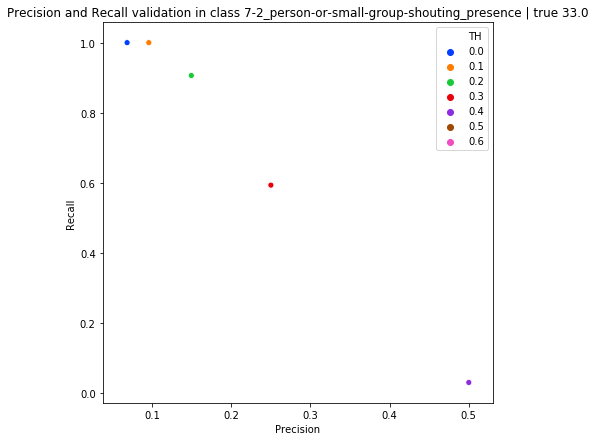

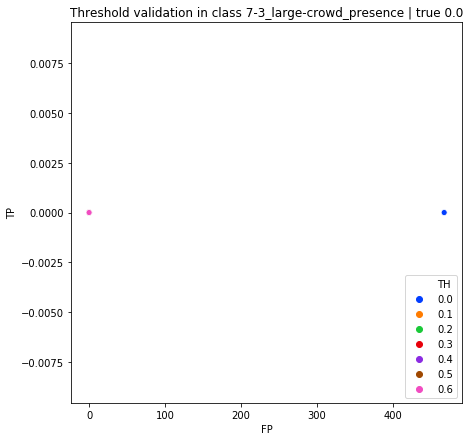

Computed 468 files over 538 total available with annotator 0


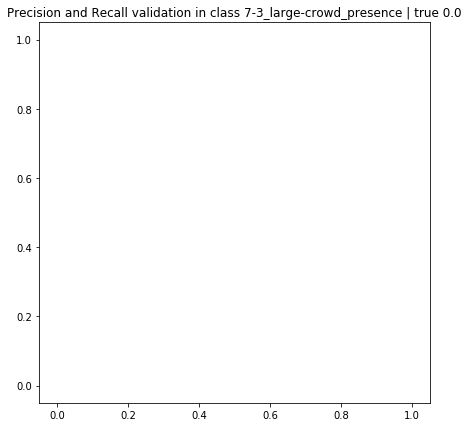

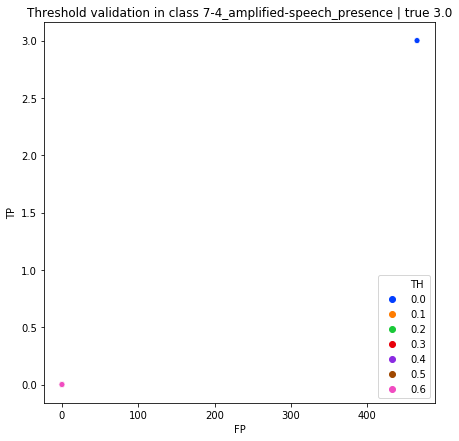

Computed 468 files over 538 total available with annotator 0


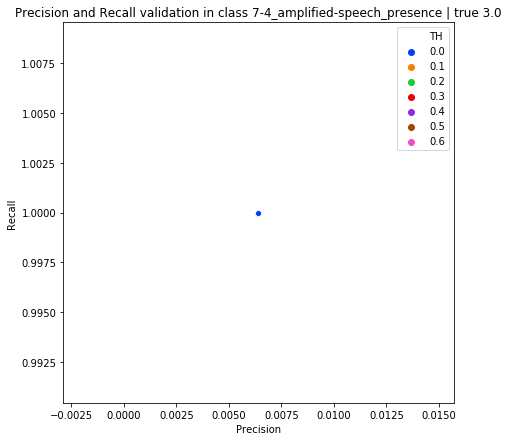

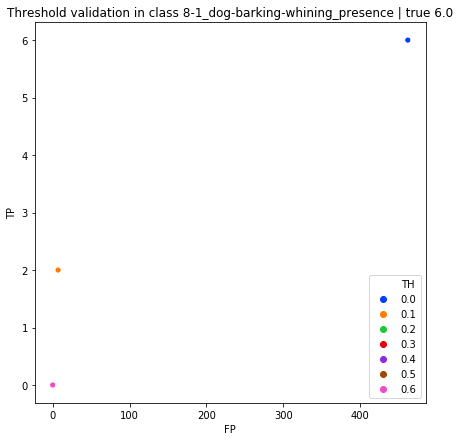

Computed 468 files over 538 total available with annotator 0


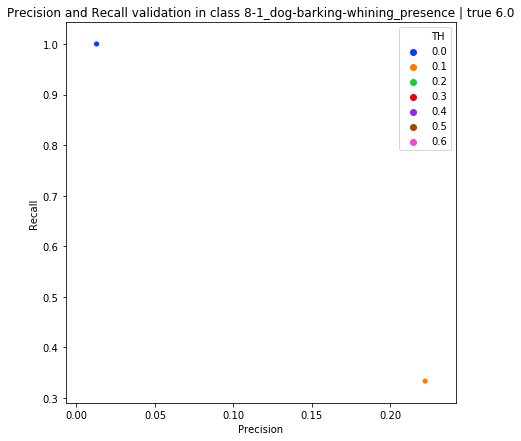

In [19]:
classes = [13, 18, 11, 1]  # classes of interest
classes = np.arange(len(classes_fine))  # all classes
thresholds = np.round(np.arange(0.0, 0.7, 0.1), 2)
res = {}

for c in classes: 
    results = []
    for th in thresholds:
        files = []
        for f in validate_data:
            gth_recording = annotations[(annotations['audio_filename']==f) & (annotations['annotator_id']==0)]
            if np.any(gth_recording): # skip if no annotator 0
                if np.any(gth_recording[gth_recording[unknown]==1]): # skip if X class
                        continue
                gth = gth_recording[classes_fine+['audio_filename']].set_index(['audio_filename'])
                gth = np.array(gth).astype(float)
                y_pred_ = np.array(fine_predictions[f[:-4]])
                y_pred_ = np.max(y_pred_, axis=0)
                y_pred = np.zeros(y_pred_.shape)
                y_pred[y_pred_>th] = 1
                gth = gth[:,c]
                y_pred = y_pred[c]
                true_positives_fine = ((y_pred == gth) & (gth==1)).sum()
                false_positives_fine = ((y_pred != gth) & (y_pred==1)).sum()
                false_negatives_fine = ((y_pred != gth) & (y_pred==0)).sum()
                files.append(f)
                results.append([true_positives_fine, false_positives_fine, th, false_negatives_fine])
        
    # scatter results
    results = np.array(results)
    df = pd.DataFrame({'TP':results[:, 0], 'FP':results[:, 1], 'FN': results[:,3], 'TH':results[:, 2]})
    df_ = df.groupby(['TH']).sum().reset_index()
    df_['Precision'] = df_['TP']/(df_['TP']+df_['FP'])
    df_['Recall'] = df_['TP']/(df_['TP']+df_['FN'])
    
    # TP vs. FP
    palette = sns.color_palette("bright", len(thresholds))
    plt.figure(figsize=(7,7))
    plt.title('Threshold validation in class {} | true {}'.format(classes_fine[c], 
                                                                  annotations[(annotations['split']=='validate')
                                                      & (annotations['annotator_id']==0)][classes_fine[c]].sum()))
    ax = sns.scatterplot(x="FP", y="TP", hue='TH',
                         data=df_, legend='full', palette=palette)
    ax.legend(loc='lower right', ncol=1)
    plt.show()        
    
    # Recall vs. Precision
    plt.figure(figsize=(7,7))
    plt.title('Precision and Recall validation in class {} | true {}'.format(classes_fine[c], 
                                                                      annotations[(annotations['split']=='validate')
                                                          & (annotations['annotator_id']==0)][classes_fine[c]].sum()))
    ax = sns.scatterplot(x="Precision", y="Recall", hue='TH',
                         data=df_, legend='full', palette=palette)
    res[classes_fine[c]] = results
    print('Computed {} files over {} total available with annotator 0'.format(len(files), len(validate_data)))

In [20]:
df = pd.DataFrame({'TP':results[:, 0], 'FP':results[:, 1], 'FN': results[:,3], 'TH':results[:, 2]})
df_ = df.groupby(['TH']).sum().reset_index()
df_['Precision'] = df_['TP']/(df_['TP']+df_['FP'])
df_['Recall'] = df_['TP']/(df_['TP']+df_['FN'])
df_

,TH,TP,FP,FN,Precision,Recall
0,0.0,6.0,462.0,0.0,0.012821,1.000000
1,0.1,2.0,7.0,4.0,0.222222,0.333333
2,0.2,0.0,0.0,6.0,NaN,0.000000
3,0.3,0.0,0.0,6.0,NaN,0.000000
4,0.4,0.0,0.0,6.0,NaN,0.000000
5,0.5,0.0,0.0,6.0,NaN,0.000000
6,0.6,0.0,0.0,6.0,NaN,0.000000
